# Start to end test

Before runing this test, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
import os
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')
MASK_RCNN_MODEL_PATH = os.path.join(NOMEROFF_NET_DIR, "models/mask_rcnn_numberplate_0700.h5")
OPTIONS_MODEL_PATH =  os.path.join(NOMEROFF_NET_DIR, "models/numberplate_options_2019_03_05.h5")

mode =  "cpu"
OCR_NP_UKR_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ua_12-{}.h5".format(mode))
OCR_NP_EU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_eu_2-{}.h5".format(mode))
OCR_NP_RU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ru_3-{}.h5".format(mode))

sys.path.append(NOMEROFF_NET_DIR)

In [2]:
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessingAsync

nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load(OPTIONS_MODEL_PATH)

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": OCR_NP_UKR_TEXT
    },
    "eu": {
        "for_regions": ["eu", "eu_ua_1995"],
        "model_path": OCR_NP_EU_TEXT
    },
    "ru": {
        "for_regions": ["ru"],
        "model_path": OCR_NP_RU_TEXT
    }
})

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [15]:
import cv2
import numpy as np

async def test(dirName, fname, y, verbose=0, max_img_w = 1000):
    img_path = os.path.join(dirName, fname)
    if verbose==1:
        print(colored(f"__________ \t\t {img_path} \t\t __________", "blue"))
    img = mpimg.imread(img_path)
    nGood = 0
    nBad = 0
    img_path = os.path.join(dirName, fname)
    #if verbose:
    #     print(img_path)
    img = mpimg.imread(img_path)

    # corect size for better speed
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_w_r = 1
    img_h_r = 1
    if img_w > max_img_w:
        resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
        img_w_r = img_w/max_img_w
        img_h_r = img_h/(max_img_w/img_w*img_h)
    else:
        resized_img = img

    NP = nnet.detect([resized_img]) 
    
    # Generate image mask.
    cv_img_masks = await filters.cv_img_mask_async(NP)
    
    #################################
    arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=3-img_w_r, fixGeometry=False, fixRectangleAngle=10)
    arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
    arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
    toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
    if verbose:
        print("old")
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()
    ##################################
            
    # Detect points.
    arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=3-img_w_r, fixGeometry=True, fixRectangleAngle=10)
    arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
    arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
    
    # cut zones
    zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
    toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
    if verbose:
        print("new")
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()

    # find standart
    regionIds, stateIds = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    if verbose:
        print(regionNames)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames)
    textArr = await textPostprocessingAsync(textArr, regionNames)
    if verbose:
        print(textArr)
    
    for yText in y:
        if yText in textArr:
            print(colored(f"OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path}", 'green'))
            nGood += 1
        else:
            print(colored(f"NOT OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path} ", 'red'))
            nBad += 1
    return nGood, nBad

In [16]:
dirName = "images/"

__________ 		 images/0.jpeg 		 __________
old


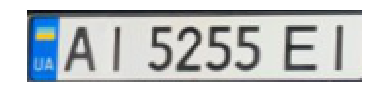

new


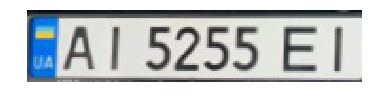

['eu_ua_2015']
['AI5255EI']
OK: TEXT:AI5255EI 			 RESULTS:['AI5255EI'] 
					 in PATH:images/0.jpeg
__________ 		 images/1.jpeg 		 __________
old


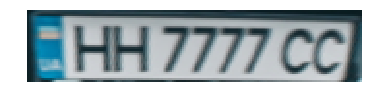

new


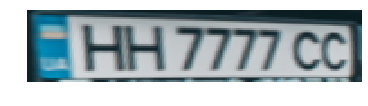

['eu_ua_2015']
['HH7777CC']
OK: TEXT:HH7777CC 			 RESULTS:['HH7777CC'] 
					 in PATH:images/1.jpeg
__________ 		 images/2.jpeg 		 __________
old


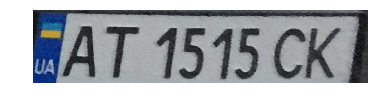

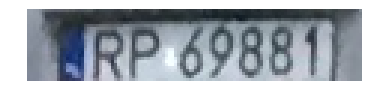

new


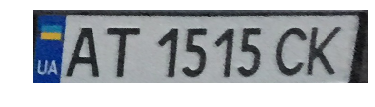

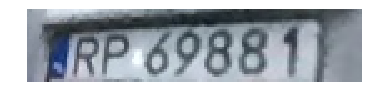

['eu_ua_2015', 'eu_ua_2015']
['AT1515CK', 'PB9881I']
OK: TEXT:AT1515CK 			 RESULTS:['AT1515CK', 'PB9881I'] 
					 in PATH:images/2.jpeg
__________ 		 images/3.jpeg 		 __________
old


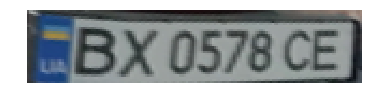

new


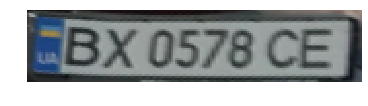

['eu_ua_2015']
['BX0578CE']
OK: TEXT:BX0578CE 			 RESULTS:['BX0578CE'] 
					 in PATH:images/3.jpeg
__________ 		 images/4.jpeg 		 __________
old


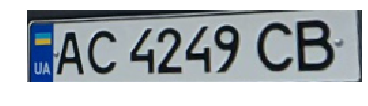

new


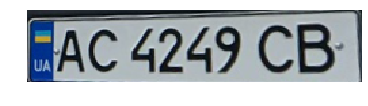

['eu_ua_2015']
['AC4249CB']
OK: TEXT:AC4249CB 			 RESULTS:['AC4249CB'] 
					 in PATH:images/4.jpeg
__________ 		 images/5.jpeg 		 __________
old


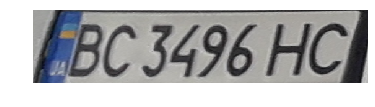

new


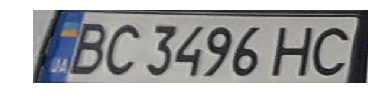

['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:images/5.jpeg
__________ 		 images/6.jpeg 		 __________
old


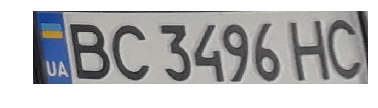

new


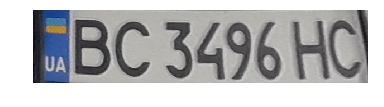

['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:images/6.jpeg
__________ 		 images/7.jpeg 		 __________
old


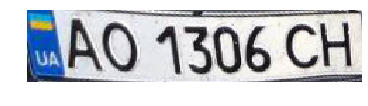

new


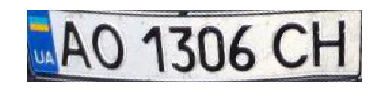

['eu_ua_2015']
['AO1306CH']
OK: TEXT:AO1306CH 			 RESULTS:['AO1306CH'] 
					 in PATH:images/7.jpeg
__________ 		 images/8.jpeg 		 __________
old


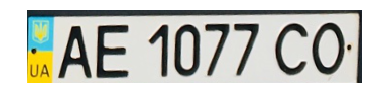

new


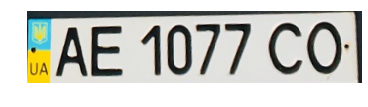

['eu_ua_2004']
['AE1077CO']
OK: TEXT:AE1077CO 			 RESULTS:['AE1077CO'] 
					 in PATH:images/8.jpeg
__________ 		 images/9.jpeg 		 __________
old


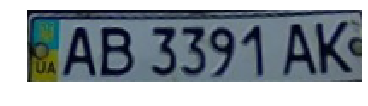

new


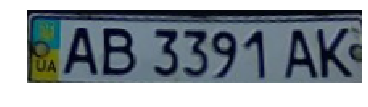

['eu_ua_2004']
['AB3391AK']
OK: TEXT:AB3391AK 			 RESULTS:['AB3391AK'] 
					 in PATH:images/9.jpeg
__________ 		 images/10.jpeg 		 __________
old


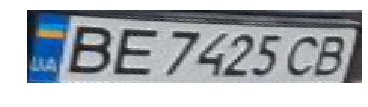

new


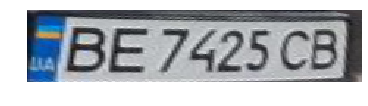

['eu_ua_2015']
['BE7425CB']
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:images/10.jpeg
__________ 		 images/11.jpeg 		 __________
old


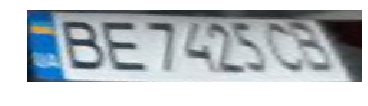

new


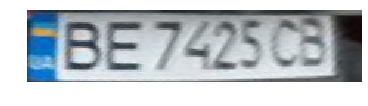

['eu_ua_2015']
['BE7425CB']
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:images/11.jpeg
__________ 		 images/12.jpeg 		 __________
old


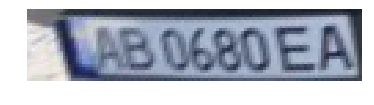

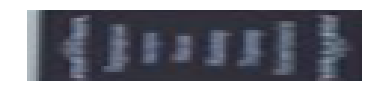

new


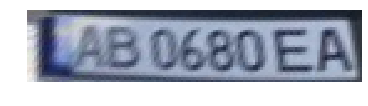

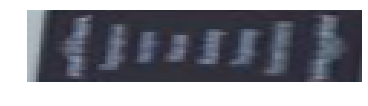

['eu_ua_2015', 'xx_unknown']
['AB0680EA', '']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA', ''] 
					 in PATH:images/12.jpeg
__________ 		 images/13.jpeg 		 __________
old


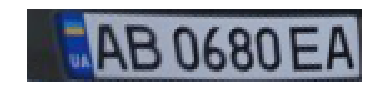

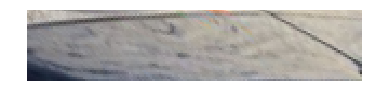

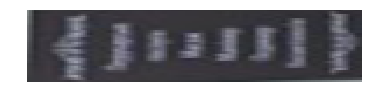

new


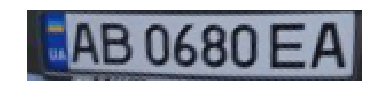

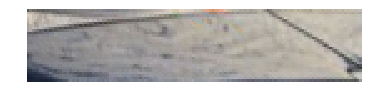

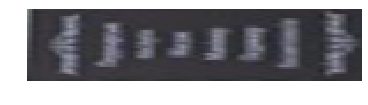

['eu_ua_2015', 'xx_unknown', 'xx_unknown']
['AB0680EA', '', '']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA', '', ''] 
					 in PATH:images/13.jpeg
__________ 		 images/14.jpeg 		 __________
old


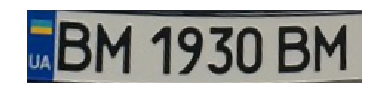

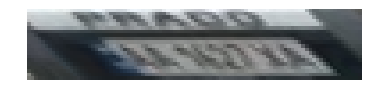

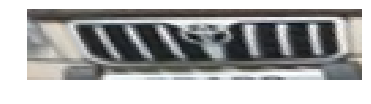

new


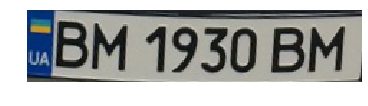

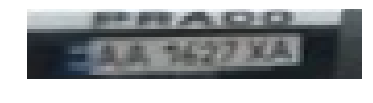

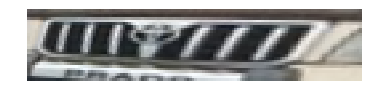

['eu_ua_2015', 'xx_unknown', 'xx_unknown']
['BM1930BM', '', '']
OK: TEXT:BM1930BM 			 RESULTS:['BM1930BM', '', ''] 
					 in PATH:images/14.jpeg
__________ 		 images/15.jpeg 		 __________
old


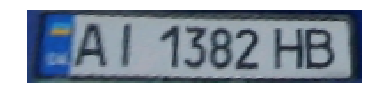

new


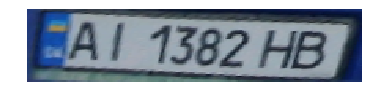

['eu_ua_2015']
['AI1382HB']
OK: TEXT:AI1382HB 			 RESULTS:['AI1382HB'] 
					 in PATH:images/15.jpeg
__________ 		 images/16.jpeg 		 __________
old


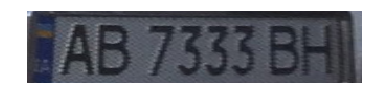

new


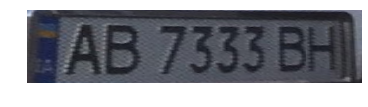

['eu_ua_2015']
['AB7333BH']
OK: TEXT:AB7333BH 			 RESULTS:['AB7333BH'] 
					 in PATH:images/16.jpeg
__________ 		 images/17.jpeg 		 __________
old


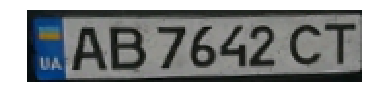

new


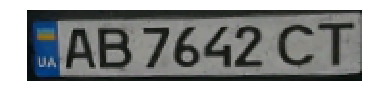

['eu_ua_2015']
['AB7642CT']
OK: TEXT:AB7642CT 			 RESULTS:['AB7642CT'] 
					 in PATH:images/17.jpeg
__________ 		 images/18.jpeg 		 __________
old


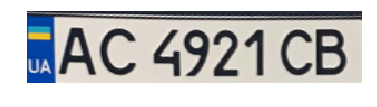

new


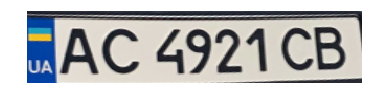

['eu_ua_2015']
['AC4921CB']
OK: TEXT:AC4921CB 			 RESULTS:['AC4921CB'] 
					 in PATH:images/18.jpeg
__________ 		 images/19.jpeg 		 __________
old


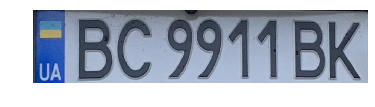

new


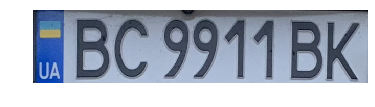

['eu_ua_2015']
['BC9911BK']
OK: TEXT:BC9911BK 			 RESULTS:['BC9911BK'] 
					 in PATH:images/19.jpeg
__________ 		 images/20.jpeg 		 __________
old


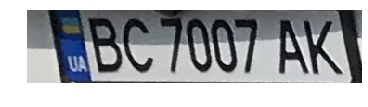

new


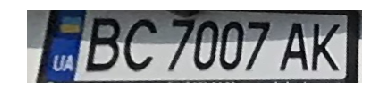

['eu_ua_2015']
['BC7007AK']
OK: TEXT:BC7007AK 			 RESULTS:['BC7007AK'] 
					 in PATH:images/20.jpeg
__________ 		 images/21.jpeg 		 __________
old


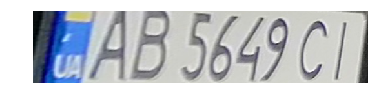

new


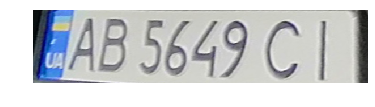

['eu_ua_2015']
['AB5649CI']
OK: TEXT:AB5649CI 			 RESULTS:['AB5649CI'] 
					 in PATH:images/21.jpeg
__________ 		 images/22.jpeg 		 __________
old


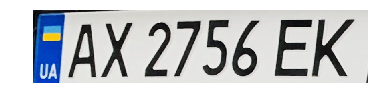

new


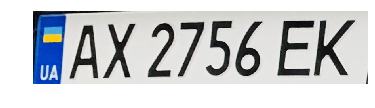

['eu_ua_2015']
['AX2756EK']
OK: TEXT:AX2756EK 			 RESULTS:['AX2756EK'] 
					 in PATH:images/22.jpeg
__________ 		 images/23.jpeg 		 __________
old


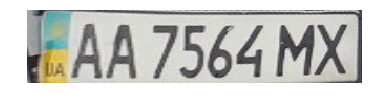

new


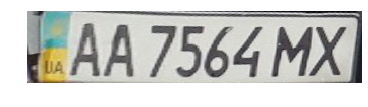

['eu_ua_2004']
['AA7564MX']
OK: TEXT:AA7564MX 			 RESULTS:['AA7564MX'] 
					 in PATH:images/23.jpeg
__________ 		 images/24.jpeg 		 __________
old


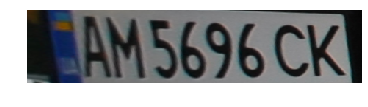

new


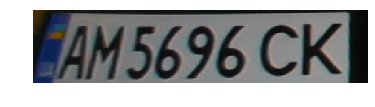

['eu_ua_2015']
['AM5696CK']
OK: TEXT:AM5696CK 			 RESULTS:['AM5696CK'] 
					 in PATH:images/24.jpeg
__________ 		 images/25.jpeg 		 __________
old


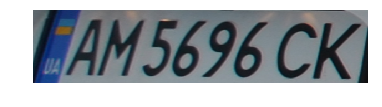

new


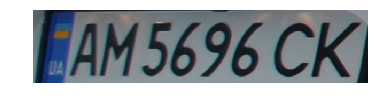

['eu_ua_2015']
['AM5696CK']
OK: TEXT:AM5696CK 			 RESULTS:['AM5696CK'] 
					 in PATH:images/25.jpeg
TOTAL GOOD: 1.0
TOTAL BED: 0.0


In [17]:
testData = {
    "0.jpeg": ["AI5255EI"],
    "1.jpeg": ["HH7777CC"],
    "2.jpeg": ["AT1515CK"],
    "3.jpeg": ["BX0578CE"],
    "4.jpeg": ["AC4249CB"],
    "5.jpeg": ["BC3496HC"],
    "6.jpeg": ["BC3496HC"],
    "7.jpeg": ["AO1306CH"],
    "8.jpeg": ["AE1077CO"],
    "9.jpeg": ["AB3391AK"],
    "10.jpeg": ["BE7425CB"],
    "11.jpeg": ["BE7425CB"],
    "12.jpeg": ["AB0680EA"],
    "13.jpeg": ["AB0680EA"],
    "14.jpeg": ["BM1930BM"],
    "15.jpeg": ["AI1382HB"],
    "16.jpeg": ["AB7333BH"],
    "17.jpeg": ["AB7642CT"],
    "18.jpeg": ["AC4921CB"],
    "19.jpeg": ["BC9911BK"],
    "20.jpeg": ["BC7007AK"],
    "21.jpeg": ["AB5649CI"],
    "22.jpeg": ["AX2756EK"],
    "23.jpeg": ["AA7564MX"],
    "24.jpeg": ["AM5696CK"],
    "25.jpeg": ["AM5696CK"],
}

gGood = 0
gBad = 0
i = 0
for fileName in testData.keys():
    nGood, nBad = await test(dirName, fileName, testData[fileName], verbose=1)
    gGood += nGood
    gBad += nBad
    i += 1
total = gGood + gBad
print(f"TOTAL GOOD: {gGood/total}")
print(f"TOTAL BED: {gBad/total}")

__________ 		 images/6.jpeg 		 __________
old


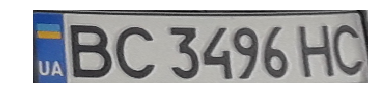

new


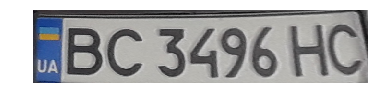

['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:images/6.jpeg


(1, 0)

In [18]:
await test(dirName, "6.jpeg", ["BC3496HC"], verbose=1, max_img_w = 1600)